In [1]:
import os
import time
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from datetime import datetime
from PIL import Image

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# Custom dataset folder
#dataset_path = 'F:/vit_custom_img_classif/key_desc_org'  # Update this path
dataset_path = 'dataset_ebs'

In [3]:
# Preset values
dropout_rate = 0.00
batch_size = 32
learning_rate = 1e-4
num_epochs = 10
image_size = 224

In [4]:
# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=(0, 360)),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    #transforms.RandomResizedCrop(size=image_size),
    #transforms.RandomPerspective(distortion_scale=0.5, probability=0.5),
    #transforms.RandomVerticalFlip(),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.0),
])

In [5]:
# Load custom dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

In [6]:
# Split dataset into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
# List of Vit Models with Pretrained Weight
all_models = timm.list_models('*')
all_models

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_small',
 'coat_tiny',
 'coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_r

In [9]:
mypretrainedname = 'mobilevit_xxs' #Put one of the model name listed in previous cell

In [10]:
# Load pre-trained ViT model with specified dropout rate
model = timm.create_model(mypretrainedname, pretrained=True, num_classes=num_classes, drop_rate=dropout_rate)
model = model.to(device)

In [11]:
# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Summary info before training loop
print(f"Custom dataset folder: {dataset_path}")
print(f"Number of classes: {num_classes} with class names: {class_names}")
print(f"Preset dropout rate: {dropout_rate}")
print(f"Training/Testing Ratio: {train_size}/{val_size}")
print(f"Learning rate: {learning_rate}")

Custom dataset folder: dataset_ebs
Number of classes: 2 with class names: ['goods', 'rejects']
Preset dropout rate: 0.0
Training/Testing Ratio: 491/211
Learning rate: 0.0001


In [13]:
# Training and validation
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

In [14]:
# Continue training start here
start_time = time.time()  # Start time of the training

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the current epoch

    # [Your existing training and validation code goes here]

    # Calculate average losses and accuracy
    # [Your existing code for calculating and storing training/validation losses and accuracies]
    # Training
    model.train()
    train_loss, train_correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)
    
    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)
    
    # Calculate average losses and accuracy
    train_loss = train_loss / train_size
    train_acc = train_correct.double() / train_size
    val_loss = val_loss / val_size
    val_acc = val_correct.double() / val_size

    # Save history for plotting
    train_acc_history.append(train_acc.cpu().numpy())
    train_loss_history.append(train_loss)
    val_acc_history.append(val_acc.cpu().numpy())
    val_loss_history.append(val_loss)

    
    epoch_time = time.time() - epoch_start_time  # Time taken for the current epoch
    total_time = time.time() - start_time  # Total time elapsed since the start of training
    avg_time_per_epoch = total_time / (epoch + 1)  # Average time per epoch
    remaining_epochs = num_epochs - epoch - 1
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert estimated remaining time from seconds to minutes
    estimated_remaining_time_min = estimated_remaining_time / 60

    # Print results every epoch with estimated remaining time
    print(f"Epoch {epoch+1}/{num_epochs}.. "
          f"Train loss: {train_loss:.4f}.. "
          f"Train accuracy: {train_acc:.4f}.. "
          f"Val loss: {val_loss:.4f}.. "
          f"Val accuracy: {val_acc:.4f}.. "
          f"Remaining time: {estimated_remaining_time_min:.2f} minutes")

Epoch 1/10.. Train loss: 0.6537.. Train accuracy: 0.8717.. Val loss: 0.6194.. Val accuracy: 0.8863.. Remaining time: 4.39 minutes
Epoch 2/10.. Train loss: 0.5234.. Train accuracy: 0.9837.. Val loss: 0.4598.. Val accuracy: 0.9005.. Remaining time: 4.01 minutes
Epoch 3/10.. Train loss: 0.3965.. Train accuracy: 0.9898.. Val loss: 0.2921.. Val accuracy: 0.9905.. Remaining time: 3.59 minutes
Epoch 4/10.. Train loss: 0.2901.. Train accuracy: 0.9939.. Val loss: 0.2081.. Val accuracy: 0.9858.. Remaining time: 3.12 minutes
Epoch 5/10.. Train loss: 0.2164.. Train accuracy: 0.9959.. Val loss: 0.1650.. Val accuracy: 0.9953.. Remaining time: 2.62 minutes
Epoch 6/10.. Train loss: 0.1742.. Train accuracy: 0.9939.. Val loss: 0.1414.. Val accuracy: 1.0000.. Remaining time: 2.10 minutes
Epoch 7/10.. Train loss: 0.1316.. Train accuracy: 0.9980.. Val loss: 0.1041.. Val accuracy: 0.9953.. Remaining time: 1.58 minutes
Epoch 8/10.. Train loss: 0.1045.. Train accuracy: 1.0000.. Val loss: 0.0904.. Val accuracy

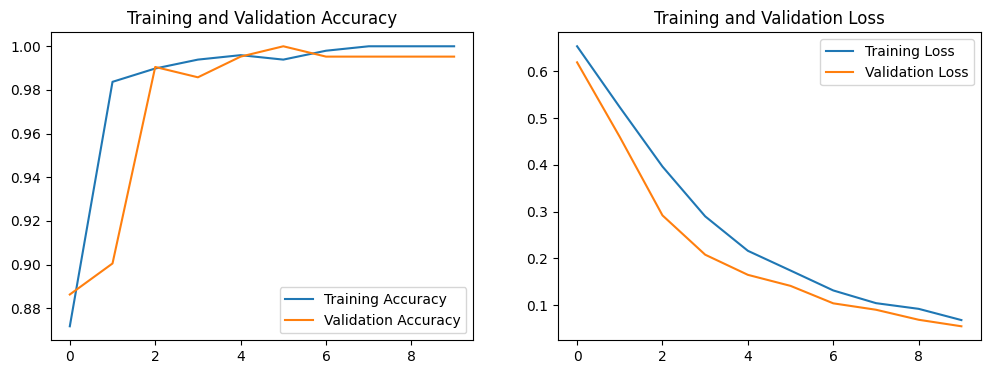

In [15]:
# Plot trend chart for Accuracy and Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Save the model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_save_path = os.path.join(dataset_path, mypretrainedname + f'_{timestamp}.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to dataset_ebs\mobilevit_xxs_20240109_125557.pth


In [17]:
# Predict Function
def predict_image(image_path, model, device, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    inputs = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    _, predicted_confidence = torch.max(confidence, 0)
    
    plt.imshow(image)
    plt.title(f"{class_names[predicted]} ({confidence[predicted].item():.2f}%)") #({confidence[predicted]:.2f}%)
    plt.show()

In [18]:
# Load the model weights 
filename = model_save_path
#filename = dataset_path + "/" + "model_20231220_105848.pth"

loaded_weights = torch.load(filename)

# load the weights 
model.load_state_dict(loaded_weights)

<All keys matched successfully>

In [19]:
print (class_names)

['goods', 'rejects']


In [20]:
# Your existing predict_image function
def predict_image(image_path, model, device, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    inputs = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
    return class_names[predicted[0]], confidence[predicted[0]].item(), image


In [21]:
from tqdm.notebook import tqdm  # Use tqdm.notebook.tqdm for Jupyter Notebook

def process_folders(image_folder_path, model, device, transform, class_names):
    total_images = 0
    misclassified_images = 0
    total_prediction_time = 0
    
    # Get the list of class folders
    class_folders = [f for f in os.listdir(image_folder_path) if os.path.isdir(os.path.join(image_folder_path, f))]
    
    # Wrap the loop with tqdm for the progress bar
    for class_folder in tqdm(class_folders, desc='Processing folders'):
        folder_path = os.path.join(image_folder_path, class_folder)
        
        # Get the list of image files
        image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        
        # Wrap the loop with tqdm for the progress bar
        for image_file in tqdm(image_files, desc=f'Processing {class_folder}', leave=False):
            total_images += 1
            image_path = os.path.join(folder_path, image_file)
            
            start_time = time.time()
            predicted_label, confidence, image = predict_image(image_path, model, device, transform, class_names)
            prediction_time = time.time() - start_time
            total_prediction_time += prediction_time
            
            # Count and show image if misclassified
            if predicted_label != class_folder:
                misclassified_images += 1
                plt.imshow(image)
                plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%), Actual: {class_folder}")
                plt.show()

    # Calculate and display results
    if total_images > 0:
        misclassification_percentage = (misclassified_images / total_images) * 100
        average_prediction_time = total_prediction_time / total_images
        print(f"Total Images: {total_images}")
        print(f"Misclassified Images: {misclassified_images}")
        print(f"Misclassification Percentage: {misclassification_percentage:.2f}%")
        print(f"Average Prediction Time per Image: {average_prediction_time:.4f} seconds")
    else:
        print("No images found in the provided folder.")

# Example usage:
# process_folders('path_to_image_folder', model, device, transform, class_names)

Processing folders:   0%|          | 0/2 [00:00<?, ?it/s]

Processing goods:   0%|          | 0/468 [00:00<?, ?it/s]

Processing rejects:   0%|          | 0/234 [00:00<?, ?it/s]

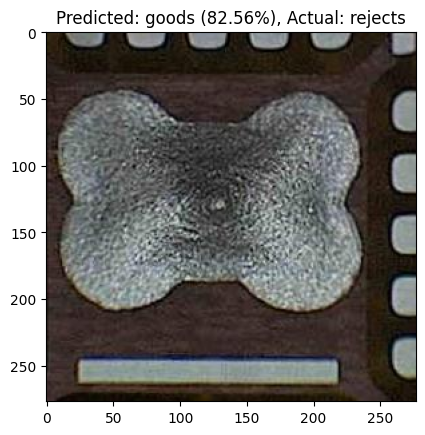

Total Images: 702
Misclassified Images: 1
Misclassification Percentage: 0.14%
Average Prediction Time per Image: 0.0494 seconds


In [22]:
# Example usage
image_folder_path = dataset_path #'path_to_your_image_folder'
# model, device, transform, and class_names need to be defined as per your model and dataset
process_folders(image_folder_path, model, device, transform, class_names)
